<a href="https://colab.research.google.com/github/chwon9-jpg/Diffusion_models/blob/main/Diffusion_model_2_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepinv

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import time
import math

# ----------------------------
# Sinusoidal Positional Embedding used in Transformers (used for timestep embedding)
# ----------------------------
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None].float() * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


# ----------------------------
# Self-Attention Block
# ----------------------------
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.proj_query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.proj_key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.proj_value = nn.Conv2d(channels, channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        # 1x1 convolutional layers act as linear transformations

    def forward(self, x):
        B, C, H, W = x.size()  # Batch_size, Channels, Height, Width

        query = self.proj_query(x).view(B, -1, H * W).permute(0, 2, 1)  # B, HW, C/8
        key = self.proj_key(x).view(B, -1, H * W)                      # B, C/8, HW

        energy = torch.bmm(query, key)
        attention = F.softmax(energy, dim=-1)

        value = self.proj_value(x).view(B, -1, H * W)                   # B, C, HW

        out = torch.bmm(value, attention.permute(0, 2, 1)) # B, C, HW
        out = out.view(B, C, H, W)

        out = self.gamma * out + x
        return out


# ----------------------------
# Simple UNet for MNIST Diffusion
# ----------------------------
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, hidden_dim=32):
        super().__init__()

        # Encoder
        self.enc1 = nn.Conv2d(in_channels, hidden_dim, 3, padding=1)

        self.enc2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 3, padding=1)

        self.enc3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 3, padding=1)

        self.enc4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 3, padding=1)


        # Attention after deepest encoder
        self.attn1 = SelfAttention(hidden_dim * 8)

        # Bottleneck
        self.bottleneck = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 3, padding=1)

        # Attention after bottleneck
        self.attn2 = SelfAttention(hidden_dim * 8)


        # Decoder
        self.dec4 = nn.Conv2d(hidden_dim * 8 + hidden_dim * 4, hidden_dim * 4, 3, padding=1)

        self.dec3 = nn.Conv2d(hidden_dim * 4 + hidden_dim * 2, hidden_dim * 2, 3, padding=1)

        self.dec2 = nn.Conv2d(hidden_dim * 2 + hidden_dim, hidden_dim, 3, padding=1)

        self.attn3 = SelfAttention(hidden_dim)

        self.dec1 = nn.Conv2d(hidden_dim + in_channels, out_channels, 3, padding=1)




        # Timestep embedding: Using Sinusoidal Positional Embedding + MLP
        time_embedding_dim = hidden_dim * 4 # Intermediate dim for sinusoidal embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(dim=time_embedding_dim),
            nn.Linear(time_embedding_dim, hidden_dim * 8), # Project to final bottleneck dim
            nn.SiLU(),
            nn.Linear(hidden_dim * 8, hidden_dim * 8)
        )

    def forward(self, x, t, type_t="timestep"):
        # Process timestep with positional embedding and MLP
        t_emb = self.time_mlp(t) # Output: [B, hidden_dim * 8]
        # Unsqueeze to match the spatial dimensions of the feature maps
        t_emb = t_emb.unsqueeze(-1).unsqueeze(-1)  # [B, hidden_dim * 8, 1, 1]

        # Encoder (Downsampling)
        e1 = F.silu(self.enc1(x))                     # Conv ->  -> SiLU
        p1 = F.max_pool2d(e1, 2) # both kernel filter size and stride are 2
        e2 = F.silu(self.enc2(p1))                   # Conv ->  -> SiLU
        p2 = F.max_pool2d(e2, 2)
        e3 = F.silu(self.enc3(p2))                   # Conv ->  -> SiLU
        p3 = F.max_pool2d(e3, 2)
        e4 = F.silu(self.enc4(p3))                   # Conv ->  -> SiLU

        # Attention 1
        e4_attn = self.attn1(e4)

        # Bottleneck + timestep (MidBlock)
        b = F.silu(self.bottleneck(e4_attn) + t_emb)       # Conv -> Add T_emb -> SiLU
        # 4 x 4 spatial dimension

        # Attention 2
        b_attn = self.attn2(b)

        # Decoder (Upsampling)
        u4 = F.interpolate(b_attn, scale_factor=2, mode="nearest") # Spatial dimensions are upscaled by a factor of 2
        d4 = F.silu(self.dec4(torch.cat([u4, e3], dim=1))) # Skip-connection -> Conv -> SiLU

        u3 = F.interpolate(d4, scale_factor=2, mode="nearest")
        d3 = F.silu(self.dec3(torch.cat([u3, e2], dim=1))) # Skip-connection -> Conv -> SiLU

        u2 = F.interpolate(d3, scale_factor=2, mode="nearest")
        d2 = F.silu(self.dec2(torch.cat([u2, e1], dim=1))) # Skip-connection -> Conv -> SiLU

        d2_attn = self.attn3(d2)

        # Final output (no activation or normalization after the last layer)
        out = self.dec1(torch.cat([d2_attn, x], dim=1))


        return out

In [ ]:
# ----------------------------
# Setup
# ----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}\n")

# Hyperparameters
batch_size = 128
image_size = 32
lr = 1e-3
epochs = 60
timesteps = 500
beta_start = 1e-4
beta_end = 0.02

# Data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,)),  #Converts [0,1] → [-1,1]
    transforms.Normalize((0.0,), (1.0,)),
])

print("Loading MNIST dataset...")
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)
print(f"Dataset loaded. Batches per epoch: {len(train_loader)}\n")

# Model, optimizer, loss
model = SimpleUNet(in_channels=1, out_channels=1, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = nn.MSELoss()  # Standard PyTorch loss — no deepinv needed!

# Precompute noise schedule
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Print model size
num_params = sum(p.numel() for p in model.parameters())
print(f"Model: SimpleUNet | Parameters: {num_params:,}\n")

Using device: cuda

Loading MNIST dataset...
Dataset loaded. Batches per epoch: 469

Model: SimpleUNet | Parameters: 1,823,669



In [ ]:
# ----------------------------
# Training Loop
# ----------------------------
print("Starting training...\n")
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.0
    num_batches = len(train_loader)

    for data, _ in train_loader:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # Add noise
        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad() # Avoid Gradient Accumulation
        predicted_noise = model(noised_imgs, t) # Predict noise using U-net Model as mentioned before
        loss = mse(predicted_noise, noise)
        # Backprop + Update model params
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    epoch_time = time.time() - epoch_start_time
    total_elapsed = time.time() - total_start_time

    print(f"Epoch {epoch + 1}/{epochs} | "
          f"Avg Loss: {avg_loss:.6f} | "
          f"Epoch Time: {epoch_time:.2f}s | "
          f"Total Time: {total_elapsed:.2f}s")

# ----------------------------
# Save Model
# ----------------------------

os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), "models/simple_diffusion_model.pth")
print("\nTraining finished!")
print("Model saved to models/simple_diffusion_model.pth")

Starting training...

Epoch 1/60 | Avg Loss: 0.125540 | Epoch Time: 11.44s | Total Time: 11.44s
Epoch 2/60 | Avg Loss: 0.039688 | Epoch Time: 10.90s | Total Time: 22.34s
Epoch 3/60 | Avg Loss: 0.030059 | Epoch Time: 10.94s | Total Time: 33.28s
Epoch 4/60 | Avg Loss: 0.027274 | Epoch Time: 10.98s | Total Time: 44.26s
Epoch 5/60 | Avg Loss: 0.025564 | Epoch Time: 10.91s | Total Time: 55.17s
Epoch 6/60 | Avg Loss: 0.023614 | Epoch Time: 10.95s | Total Time: 66.12s
Epoch 7/60 | Avg Loss: 0.022967 | Epoch Time: 10.91s | Total Time: 77.03s
Epoch 8/60 | Avg Loss: 0.021846 | Epoch Time: 10.88s | Total Time: 87.91s
Epoch 9/60 | Avg Loss: 0.020884 | Epoch Time: 10.84s | Total Time: 98.75s
Epoch 10/60 | Avg Loss: 0.020464 | Epoch Time: 10.86s | Total Time: 109.61s
Epoch 11/60 | Avg Loss: 0.020023 | Epoch Time: 10.86s | Total Time: 120.48s
Epoch 12/60 | Avg Loss: 0.019361 | Epoch Time: 10.92s | Total Time: 131.40s
Epoch 13/60 | Avg Loss: 0.019051 | Epoch Time: 10.93s | Total Time: 142.32s
Epoch 14

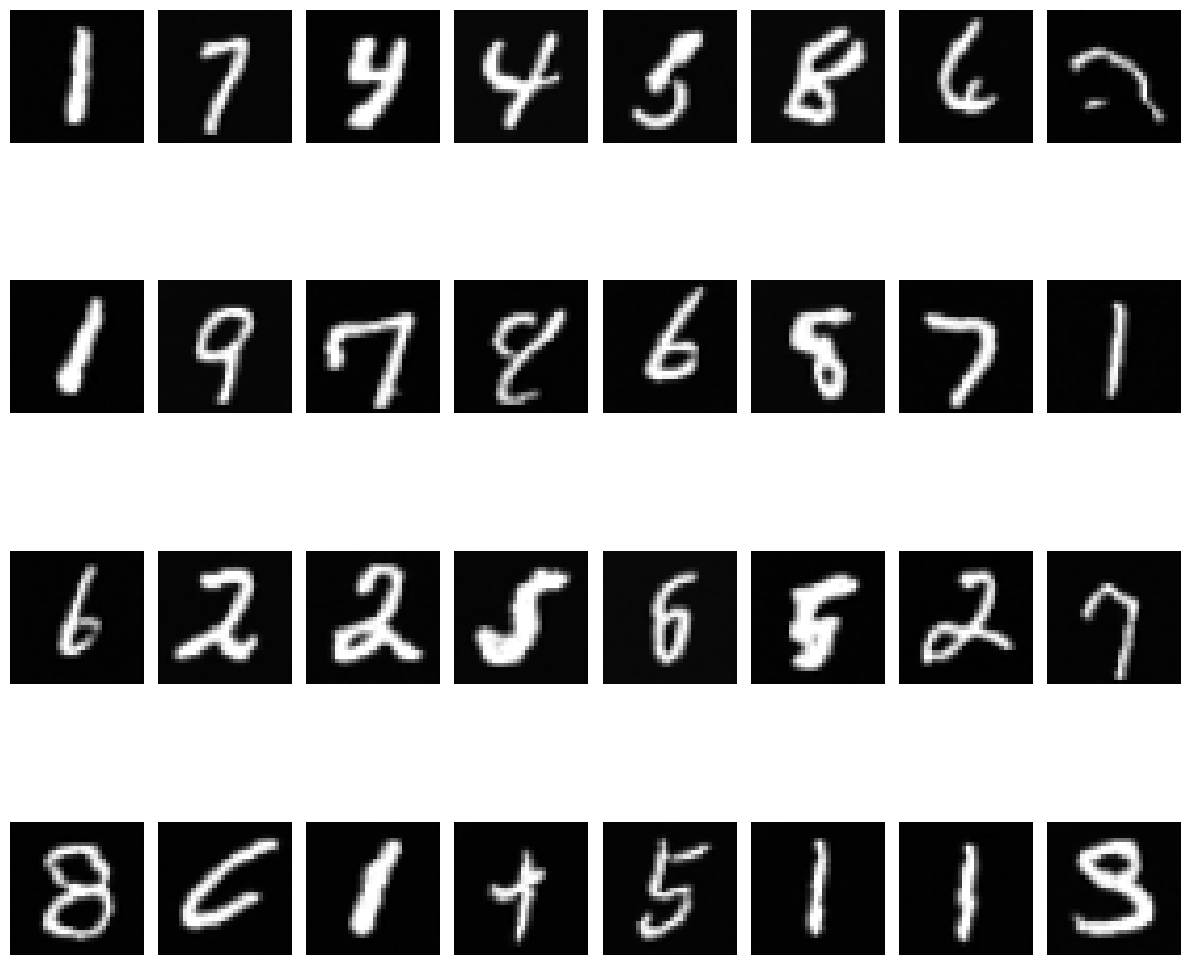

Generated 32 new MNIST-like digits!


In [ ]:
# ----------------------------
# Sampling generation
# ----------------------------

model.eval()
num_samples = 32
img_size = 32

# Start with pure noise
x_t = torch.randn(num_samples, 1, img_size, img_size, device=device)

with torch.no_grad():
    for t in reversed(range(timesteps)):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)

        # Predict noise ε_θ(x_t, t)
        predicted_noise = model(x_t, t_batch)

        # Compute mean and variance for reverse step
        alpha_t = alphas[t]
        alpha_bar_t = alphas_cumprod[t]
        alpha_bar_t_prev = alphas_cumprod[t-1] if t > 0 else torch.tensor(1.0, device=device)
        beta_t = betas[t]

        # Denoise: x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-alpha_bar_t) * predicted_noise) + sigma_t * z
        x_0_pred = (x_t - sqrt_one_minus_alphas_cumprod[t] * predicted_noise) / sqrt_alphas_cumprod[t]
        x_0_pred = torch.clamp(x_0_pred, -1, 1)  # Clip to [-1,1] for stability

        mean = x_t - ((beta_t * predicted_noise) / (sqrt_one_minus_alphas_cumprod[t]))
        mean = mean / torch.sqrt(alpha_t)

        if t == 0:
            # final step: don't add noise, just use the predicted x_0
            x_t = x_0_pred
        else:
            variance = (1 - alpha_bar_t_prev) / (1 - alpha_bar_t)
            variance = variance * beta_t
            sigma_t = variance ** 0.5
            z = torch.randn_like(x_t)  # same shape & device as x_t
            x_t = mean + sigma_t * z   # only a single tensor, no tuple


# Post-process: convert to [0,1] and detach
generated_images = (x_t.clamp(-1, 1) + 1) / 2.0  # From [-1,1] to [0,1]

# Plot generated images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(num_samples):
    ax = axes[i]
    ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Generated 32 new MNIST-like digits!")

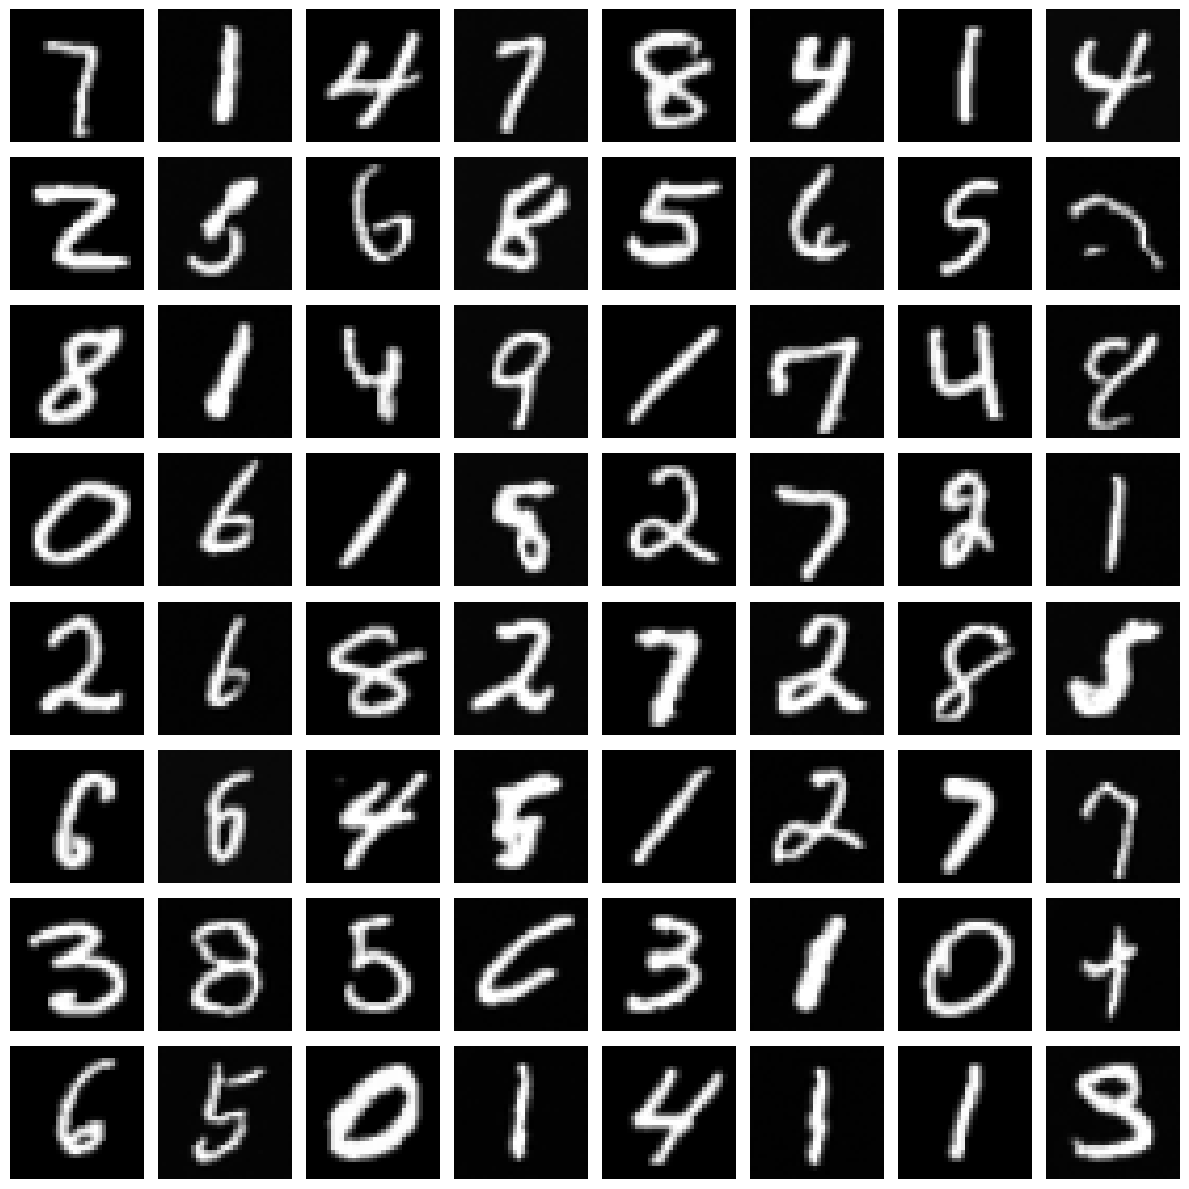

In [ ]:
# Show real MNIST for reference
real_batch = next(iter(train_loader))[0][:32].cpu()
real_batch = (real_batch + 1) / 2.0  # Only if you used Normalize((0.5,), (0.5,))

# Plot real vs generated side-by-side
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for i in range(32):
    # Real samples
    axes[i*2].imshow(real_batch[i].squeeze(), cmap='gray')
    axes[i*2].axis('off')
    # Generated samples
    axes[i*2 + 1].imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    axes[i*2 + 1].axis('off')

plt.tight_layout()
plt.show()